In [1]:
%matplotlib inline

In [2]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
sys.path.insert(0, '/home/mehdi/github/sysnetdev')
sys.path.insert(0, '/home/mehdi/github/LSSutils')

from lssutils.utils import hpix2radec
from lssutils.stats.nnbar import MeanDensity
from lssutils.dataviz import setup_color
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

from glob import glob

In [3]:
def hist(ngal, frac, syst, bins):
    ng,_,_ = binned_statistic(syst, ngal, statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst, frac, statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst, syst, statistic='mean', bins=bins)
    
    #nstd,_,_ = binned_statistic(syst, ngal/frac, statistic=np.std, bins=bins)
    #nmodes,_,_ = binned_statistic(syst, np.ones(syst.size), statistic='count', bins=bins)
    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)
    #err = nstd/np.sqrt(nmodes)
    return (ns, mean)

def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

In [4]:
df = ft.read('/home/mehdi/data/tanveer/dr8_elg_ccd_1024.fits')
print(df.dtype.names)

ngal = makehp(df['hpix'], df['label'], 1024)
syst = makehp(df['hpix'], df['features'][:, 1], 1024)
mask = makehp(df['hpix'], 1.0, 1024) > 0
frac = makehp(df['hpix'], df['fracgood'], 1024)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('label', 'features', 'hpix', 'fracgood')
[ 3. 16.]


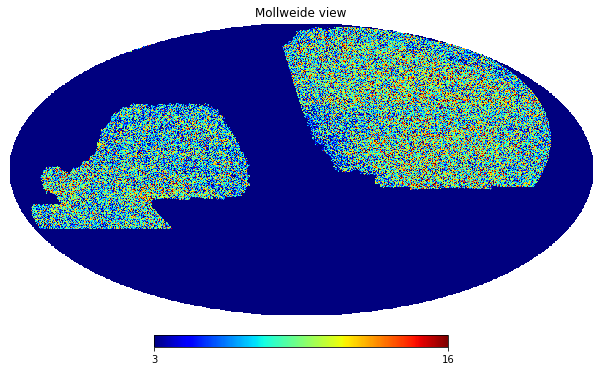

In [5]:
hp.mollview(ngal, min=3, max=16, rot=-85, cmap=plt.cm.jet)

In [6]:
bins = np.linspace(*np.percentile(syst[mask], [1, 99]), num=9)
bins

array([19.91269067, 20.03898559, 20.16528052, 20.29157544, 20.41787036,
       20.54416528, 20.6704602 , 20.79675512, 20.92305004])

In [7]:
r = {}

#nbar = MeanDensity(ngal, frac, mask, syst, bins=bins, binning='simple', nbins=8)
#nbar.run()
r['DR8 ELGs'] = hist(ngal[mask], frac[mask], syst[mask], bins)

In [9]:
windows = glob('/home/mehdi/data/tanveer/elg_mse_snapshots/windows/window_*_snapshot_*.fits')

In [11]:
for i, wind in enumerate(windows[::10]):
    w_ = ft.read(wind)
    
    w_w = w_['weight'] / w_['weight'].mean()
    w_w = w_w.clip(0.5, 2.0)    
    whp = makehp(w_['hpix'], w_w, 1024)
    
    r['mock_%d'%i] = hist(whp[mask]*frac[mask], frac[mask], syst[mask], bins)
    print('.', end='')

....................................................................................................

In [12]:
len(r.keys())

101

In [13]:
setup_color()

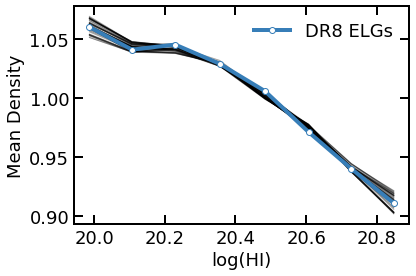

In [15]:
for name, val in r.items():
    if np.any(val[1] < 0.9):
        print(name)
        continue
    if name == 'DR8 ELGs':
        plt.plot(val[0], val[1], marker='o', mfc='w', ls='-', label=name, lw=4)
    else:
        plt.plot(val[0], val[1], lw=1, color='k', ls='-', zorder=-1, alpha=0.2)
        
plt.legend(frameon=False)
plt.xlabel('log(HI)')
plt.ylabel('Mean Density')
plt.savefig('/home/mehdi/data/tanveer/elg_mse_snapshots/ngal_loghi.png', 
            dpi=300, bbox_inches='tight')